# 인물사진을 만들어보자

## 1-1) 인물모드 직접 해보기

- 라이브러리 import 해오기

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib
import tensorflow as tf

from matplotlib import pyplot as plt


- 이미지 가져온다

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/test_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(300, 453, 3)


## 시맨틱 세그멘테이션 만들기

- DeepLabModel 이용하기
- preprocess()는 전처리, run()은 실제로 세그멘테이션을 하는 함수
- 먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리
- 모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize
- OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정
- 전처리된 이미지는 run() 함수에서 입력값으로 사용

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

- 사전에 학습된 가중치(pretrained weight)를 불러온다.
- 구글에서 제공하는 파일을 다운로드
- 구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드하고 DeepLabModel 을 초기화
- 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


- 첫 단계에서 준비한 이미지를 네트워크에 입력

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(300, 453, 3) (339, 513, 3) 15


- mg_orig 의 크기는 300x453 이고 img_resized 의 크기는 339x513 이 출력
- 이미지의 크기가 달라지면 resize된 이미지의 크기도 달라진다
- cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시한다는 점
- 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻하는 seg_map.max() 는 15
- 위에서 말씀드린 것처럼 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다. 
- 제공하는 라벨 종류는 아래와 같습니다.

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- background를 제외하면 20개의 클래스
- 우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶다. 
- 마스크를 만들고 시각화 시작

- 사람을 뜻하는 15 외 예측은 0으로 만든다.
- 그럼 예측된 세그멘테이션 이미지(map)는 최댓값이 15
- 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현
- 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화
- applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력


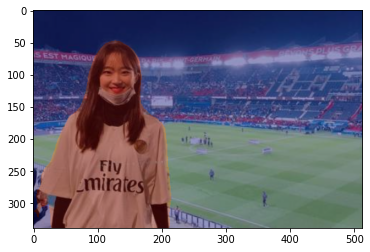

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 세그멘테이션 결과를 원래 크기로 복원하기

- DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했다.
- 따라서 출력도 resize 된 입력 크기와 같게 나오게 된다.
- 세그멘테이션 결과(mask)를 원래 크기로 복원해 본다.

In [8]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


- 사람을 뜻하는 15 외 예측은 0으로 만들었다. 
- 그럼 예측된 세그멘테이션 이미지(map)는 최댓값이 15
- 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현
- 따라서 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화
- applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력

## 세그멘테이션 결과를 원래 크기로 복원

- cv2.resize() 함수를 이용
- 크기를 키울 때 보간(interpolation) 을 고려해야 하는데요, cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
- 여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
- 결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻는다.
- 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
- 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법

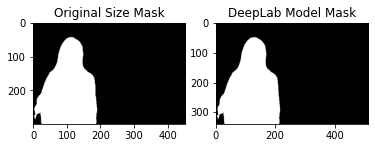

In [9]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

- 좌표축 주의

## 배경 흐리게 하기

- 배경을 흐리게 하기 위해 blur 함수를 사용한다

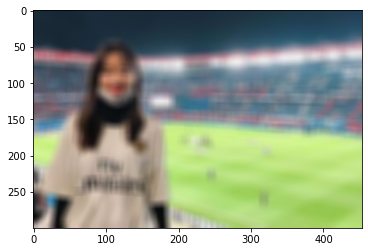

In [10]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

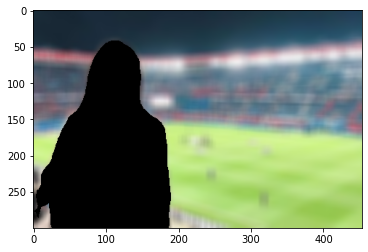

In [11]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- bitwise_not 함수를 이용하면 이미지가 반전
- 배경은 255 사람은 0
- 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있다.

## 흐린 배경과 원본 영상 합성

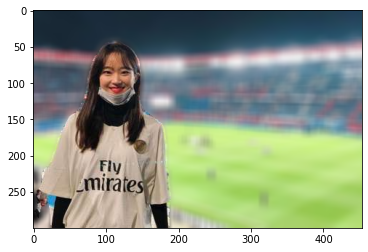

In [12]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용

## 1-2) 고양이 사진에 대입

In [87]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1746, 1080, 3)


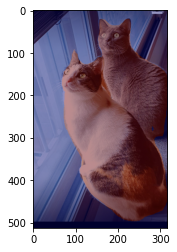

In [88]:
img_resized, seg_map = MODEL.run(img_orig)
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

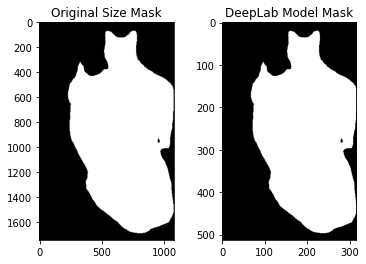

In [89]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

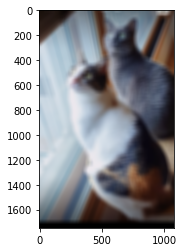

In [90]:
img_orig_blur = cv2.blur(img_orig, (43,43)) #(13,13)으로는 충분히 blurring되지 않아서 kernel size를 늘렸다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

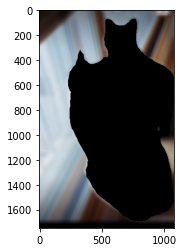

In [91]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

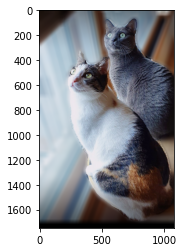

In [92]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 1-3) 배경전환 크로마키 사진

- 배경 사진을 가져온다
- 주의할 점은 배경 이미지와 고양이 이미지의 크기를 같게 설정해야한다는 점이다.

In [93]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig_b = cv2.imread(img_path) 
img_orig_b = cv2.resize(img_orig_b, (1080, 1746)) # 배경 이미지와 고양이 이미지의 크기를 같게 설정
print (img_orig_b.shape)

(1746, 1080, 3)


- 배경을 흐리게 한다

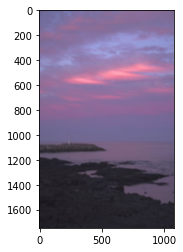

In [94]:
img_orig_blur = cv2.blur(img_orig_b, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 이미지 마스크 씌우기

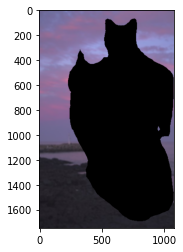

In [95]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 이미지를 합성시켜보자

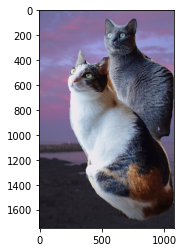

In [96]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 2) 사진에서 문제점 찾기

## 2-1) 고양이가 너무 크다
- 두 개의 사진을 그냥 합성해주니 고양이의 크기가 그대로 합성되어 부자연스럽다.
- 따라서 고양이의 크기를 줄이자

## 3) 해결 방법을 제안해 보기

In [259]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
img_orig = cv2.resize(img_orig, (500,500)) 
print (img_orig.shape)

(500, 500, 3)


In [270]:
cat_image_resize = np.zeros((1000,1000,3))
cat_image_resize[500:1000, 500:1000] = np.array(img_orig)
cat_image_resize = cat_image_resize.astype(np.uint8)
print(cat_image_resize.shape)

(1000, 1000, 3)


- 전체 사이즈를 1000 * 1000, 고양이를 전체의 0.25배 크기인 500 * 500으로 설정해준 후, 범위를 [500:1000, 500:1000] 으로 설정함으로써 
  중점을 원점으로 설정 시, 고양이가 4사분면에 위치하도록 하였다.

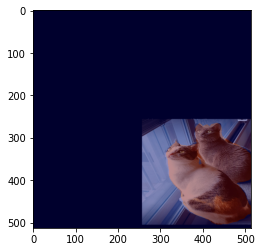

In [271]:
img_resized, seg_map = MODEL.run(cat_image_resize)
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 여기서 의문은 np.zeros의 크기를 1000 * 1000, 고양이의 크기를 500 * 500으로 설정해줬는데, 왜 plot에선 전체 그림의 크기가 500 * 500,   
  고양이의 크기는 250 * 250으로 떴을까이다.

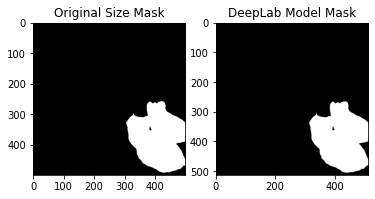

In [262]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

In [263]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig_b = cv2.imread(img_path) 
img_orig_b = cv2.resize(img_orig_b, (1080, 1746))
print (img_orig_b.shape)

(1746, 1080, 3)


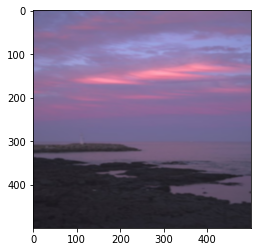

In [264]:
img_orig_blur = cv2.blur(img_orig_b, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
img_orig_blur = cv2.resize(img_orig_blur, (500,500)) 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

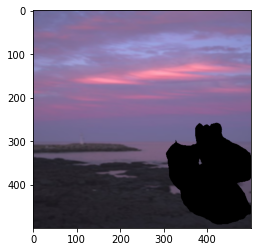

In [265]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

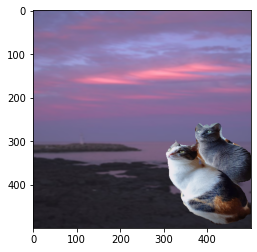

In [272]:
cat_image_resize = cv2.resize(cat_image_resize, (500,500)) 

img_concat = np.where(img_mask_color==255,cat_image_resize, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 구멍 뚤린 부분에 원본 이미지(img_orig)가 아닌 축소한 고양이 이미지(cat_image_resize)를 합성하면 된다. 

## 또 다른 해결 방법은 뭐가 있을까?

- 1) 검은색, 흰색 부분을 반대로 반전시켜서 역으로 배경을 합성시켜도 된다. 
- 2) 고양이를 가져와서 좌표 설정을 통해 배경사진에다가 붙여넣어도 된다. 